# Определение возраста покупателей по фото

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.
 
Задача: определять приблизительный возраст человека по фотографии с помощью свёрточной нейронной сети.
Требование к качеству модели: ошибка предсказания возраста, оцененная по MAE, не должна превышать 8 лет.

## Описание данных

Набор фотографий людей с указанием возраста. Данные взяты с сайта ChaLearn Looking at People.
Имеется папка со всеми изображениями (path/final_files) и CSV-файл labels.csv с двумя колонками:

 - file_name - имя файла фото;
 - real_age - реальный возраст людей на фото в годах.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
#Оценим размер выборки
labels.shape

(7591, 2)

In [4]:
print(f'Минимальный возраст - {min(labels["real_age"])}год, максимальынй возраст - {max(labels["real_age"])}лет')

Минимальный возраст - 1год, максимальынй возраст - 100лет


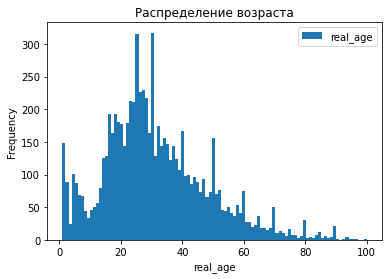

In [5]:
#График распределения возраста в выборке
labels.plot (kind='hist', title='Распределение возраста', bins = 100);
plt.xlabel('real_age');

In [6]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [7]:
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


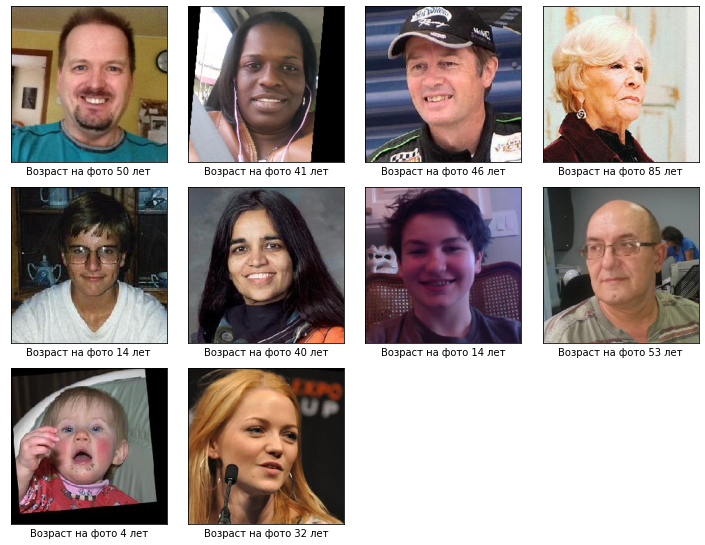

In [8]:
features, target = next(gen_flow)

# Выведем 10 изображений
fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f'Возраст на фото {target[i]} лет', fontsize=10)
    plt.tight_layout()

В датасете представлено 7591 изображений в возрасте от 1 до 100 лет. 
 
На графике распределения возраста видно, что больше всего представлены возраста от 20 лет до 40 лет. Среднее - 31, медиана - 29 лет. Возрастная группа 50+ представлена мало. 

Этого количества достаточно для того, чтобы модель не переобучалась, поэтому "замораживать" часть сети смысла нет. Для улучшения качества прогноза будем применять техники аугментации данных. А именно - фото имеют разные размеры, можно попробовать использовать обрезку/масштабирование. Разная освещенность - можно попробовать улучшить яркость/контрастность. Разные углы съемки, повороты - аугментация типа поворота.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255., 
                                       validation_split=0.25, 
                                       horizontal_flip=True, 
                                       height_shift_range=0.2,
                                       width_shift_range=0.2) 
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
                            dataframe = labels,
                            directory = path+'/final_files',
                            x_col="file_name",
                            y_col="real_age",
                            target_size = (224, 224),
                            batch_size = 64,
                            class_mode = 'raw',
                            subset = 'training',
                            seed = 12345)
    return train_datagen_flow

def load_test(path):
    
    df = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255.,
                                      validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=df,
                                                         directory=path+'/final_files',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224,224),
                                                         batch_size=64,
                                                         class_mode='raw',
                                                         subset='validation',     
                                                         seed = 12345)
      
    return  test_datagen_flow

def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.00015)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, epochs = 30, batch_size=None, steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None: 
        steps_per_epoch = len(train_data) 
    if validation_steps is None: 
        validation_steps = len(test_data)
            
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model 

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 89 steps, validate for 30 steps
Epoch 1/30
89/89 - 106s - loss: 242.9733 - mae: 11.3885 - val_loss: 1095.7964 - val_mae: 28.5698
Epoch 2/30
89/89 - 97s - loss: 92.5433 - mae: 7.2495 - val_loss: 1048.7013 - val_mae: 27.7736
Epoch 3/30
89/89 - 97s - loss: 71.1339 - mae: 6.3451 - val_loss: 1056.7510 - val_mae: 27.9134
Epoch 4/30
89/89 - 97s - loss: 54.5231 - mae: 5.6668 - val_loss: 700.0656 - val_mae: 21.2662
Epoch 5/30
89/89 - 97s - loss: 46.0722 - mae: 5.1857 - val_loss: 517.4667 - val_mae: 17.8320
Epoch 6/30
89/89 - 97s - loss: 39.5476 - mae: 4.8146 - val_loss: 235.1223 - val_mae: 11.5113
Epoch 7/30
89/89 - 97s - loss: 35.4630 - mae: 4.5983 - val_loss: 146.8286 - val_mae: 9.1058
Epoch 8/30
89/89 - 97s - loss: 30.4637 - mae: 4.2671 - val_loss: 112.8273 - val_mae: 8.0575
Epoch 9/30
Epoch 10/30
89/89 - 98s - loss: 27.3060 - mae: 4.0405 - val_loss: 87.2602 - val_mae: 6.9696
89/89 - 97s - loss: 25.6100 - mae: 3.8903 - val_loss: 102.3986 - val_mae: 7.6743
Epoch 11/30
89/89 - 98s - loss: 22.9944 - mae: 3.7197 - val_loss: 71.8181 - val_mae: 6.2140
Epoch 12/30
89/89 - 97s - loss: 20.3203 - mae: 3.4695 - val_loss: 78.6990 - val_mae: 6.7451
Epoch 13/30
89/89 - 96s - loss: 19.0642 - mae: 3.3546 - val_loss: 80.3804 - val_mae: 6.6209
Epoch 14/30
89/89 - 99s - loss: 17.2205 - mae: 3.2137 - val_loss: 62.4221 - val_mae: 5.8382
Epoch 15/30
89/89 - 98s - loss: 16.3657 - mae: 3.1131 - val_loss: 63.7360 - val_mae: 5.9385
Epoch 16/30
89/89 - 97s - loss: 14.0877 - mae: 2.9000 - val_loss: 68.5584 - val_mae: 5.9832
Epoch 17/30
89/89 - 97s - loss: 13.3655 - mae: 2.7884 - val_loss: 77.7999 - val_mae: 6.3555
Epoch 18/30
89/89 - 97s - loss: 12.8057 - mae: 2.7647 - val_loss: 66.9176 - val_mae: 6.0109
Epoch 19/30
89/89 - 97s - loss: 12.8368 - mae: 2.7369 - val_loss: 64.2591 - val_mae: 5.8347
Epoch 20/30
89/89 - 97s - loss: 11.0994 - mae: 2.5520 - val_loss: 69.5068 - val_mae: 6.0251
Epoch 21/30
89/89 - 91s - loss: 10.7640 - mae: 2.5139 - val_loss: 60.3414 - val_mae: 5.6282
Epoch 22/30
89/89 - 92s - loss: 10.6581 - mae: 2.5121 - val_loss: 62.0167 - val_mae: 5.6188
Epoch 23/30
89/89 - 93s - loss: 9.9413 - mae: 2.4260 - val_loss: 66.0006 - val_mae: 5.9793
Epoch 24/30
89/89 - 95s - loss: 9.5406 - mae: 2.3872 - val_loss: 77.0061 - val_mae: 6.5455
Epoch 25/30
89/89 - 95s - loss: 9.2016 - mae: 2.3264 - val_loss: 62.9499 - val_mae: 5.6653
Epoch 26/30
89/89 - 95s - loss: 8.8078 - mae: 2.2787 - val_loss: 70.2160 - val_mae: 6.0664
Epoch 27/30
89/89 - 94s - loss: 8.8418 - mae: 2.2639 - val_loss: 60.7178 - val_mae: 5.6506
Epoch 28/30
89/89 - 94s - loss: 8.3530 - mae: 2.2011 - val_loss: 78.6480 - val_mae: 6.4177
Epoch 29/30
89/89 - 93s - loss: 8.7555 - mae: 2.2358 - val_loss: 59.7351 - val_mae: 5.6401
Epoch 30/30
89/89 - 91s - loss: 8.3066 - mae: 2.1939 - val_loss: 63.4040 - val_mae: 5.8753
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
30/30 - 11s - loss: 63.4040 - mae: 5.8753
Test MAE: 5.8753
```

## Анализ обученной модели

Для прогноза возраста по фотографии использовалась модель ResNet50, предобученная на датасете ImageNet. Значени MAE на тестовой выборке составило 5.9 лет на 30 эпохе. В качестве функции потерь использовалась MSE, в качестве функции активации для последнего нейрона - нелинейная функция ReLU.

С помощью полученной модели удалось достичь поставленной цели, так как ошибка составляет менее 7 лет. Но можно попробовать улучшить показатели модели проанализировав на каких данных(возраст) она ошибается и в какую сторону. 